# Persistence
Here we are attempting to include temporary persistence in our workflow

## 1. Import dependencies

In [1]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import InMemorySaver                           # This is the tool that we will use to save the state temporarily in the memory as checkpoints
from langchain_ollama.chat_models import ChatOllama
from typing import TypedDict

This is for graphing purpose

In [2]:
import nest_asyncio
nest_asyncio.apply()
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import Image

## 2. Linking the model

In [3]:
llm = ChatOllama(model="llama3.1:8b")

## 3. Create a state

In [4]:
class JokeState(TypedDict):                      # The JokeState inherits a TypedDict
    topic: str
    joke: str
    explanation: str

## 4. Define the function for the graph node

In [5]:
def generate_joke(state: JokeState):

    prompt = f'generate a joke on the topic {state["topic"]}'
    response = llm.invoke(prompt).content

    return {'joke': response}

In [6]:
def generate_explanation(state: JokeState):

    prompt = f'write an explanation for the joke - {state["joke"]}'
    response = llm.invoke(prompt).content

    return {'explanation': response}

## 5. Create the graph

In [7]:
# Declare the graph:
graph = StateGraph(JokeState)                    # The StateGraph takes the state as a parameter, signifying that the "state" will be exchanged between the nodes through the edges.

# Add a nodes/states to the graph:
graph.add_node('generate_joke', generate_joke)
graph.add_node('generate_explanation', generate_explanation)

# Add the sequential edges:
graph.add_edge(START, 'generate_joke')
graph.add_edge('generate_joke', 'generate_explanation')
graph.add_edge('generate_explanation', END)

### Incorporate the checkpointer

In [8]:
checkpointer = InMemorySaver()

## 6. Compile the graph while incorporating the checkpointer

In [9]:
workflow = graph.compile(checkpointer=checkpointer)

## 7. The Graph

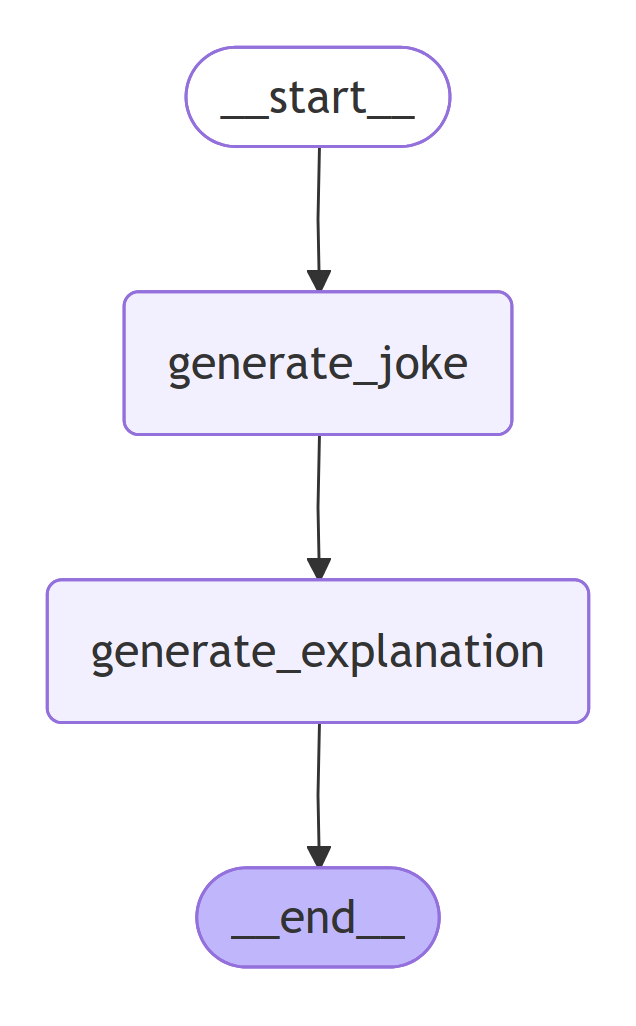

In [10]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER))

# 8. Incorporate the thread in config
To incorporate persistence, we are required to mention threads for each conversation, so that two different conversations do not pollute each other.

In [11]:
config1 = {"configurable": {"thread_id": "1"}}

In [12]:
config2 = {"configurable": {"thread_id": "2"}}

## 9. Run the code

In [13]:
# First Thread
final_state = workflow.invoke({'topic':'pizza'}, config=config1)
print(final_state)

{'topic': 'pizza', 'joke': "Here's one:\n\nWhy was the pizza in a bad mood?\n\nBecause it was feeling crusty!", 'explanation': 'A classic play on words!\n\nThe joke relies on a pun, which is a form of wordplay that exploits multiple meanings of a word or phrase. In this case, "crusty" has a double meaning.\n\nOn one hand, "crusty" can describe food that is tough and dry, like the crust of a pizza. This is likely the intended reference, as it\'s common for pizza crusts to be crispy or crunchy.\n\nHowever, "crusty" can also mean irritable or having a bad temper. Think about it: when someone is feeling grumpy or annoyed, we might say they\'re being "crusty".\n\nThe joke sets up the expectation that the answer will be related to the pizza\'s culinary characteristics (e.g., being overcooked or stale). But instead, it subverts this expectation by applying the word "crusty" to describe the pizza\'s emotional state, implying that it\'s feeling irritable. This clever twist on words creates a hu

In [14]:
# Second Thread
final_state = workflow.invoke({'topic':'pasta'}, config=config2)
print(final_state)

{'topic': 'pasta', 'joke': 'Here\'s one:\n\nWhy did the spaghetti go to therapy?\n\nBecause it was feeling a little "drained"! (get it?)', 'explanation': 'The joke is a play on words, using a common idiomatic expression in a literal sense. The phrase "feeling drained" typically means being emotionally or mentally exhausted. In this case, the punchline applies the phrase to spaghetti, which is literally a food that gets drained of its liquid (sauce) when cooked.\n\nThe humor comes from the unexpected twist on the usual meaning of the phrase, and the clever use of wordplay to create a pun. The joke requires some basic knowledge of cooking and common idioms to appreciate the clever connection between the setup and the punchline.'}


In [15]:
print(final_state)

{'topic': 'pasta', 'joke': 'Here\'s one:\n\nWhy did the spaghetti go to therapy?\n\nBecause it was feeling a little "drained"! (get it?)', 'explanation': 'The joke is a play on words, using a common idiomatic expression in a literal sense. The phrase "feeling drained" typically means being emotionally or mentally exhausted. In this case, the punchline applies the phrase to spaghetti, which is literally a food that gets drained of its liquid (sauce) when cooked.\n\nThe humor comes from the unexpected twist on the usual meaning of the phrase, and the clever use of wordplay to create a pun. The joke requires some basic knowledge of cooking and common idioms to appreciate the clever connection between the setup and the punchline.'}


In [16]:
workflow.get_state(config1)

StateSnapshot(values={'topic': 'pizza', 'joke': "Here's one:\n\nWhy was the pizza in a bad mood?\n\nBecause it was feeling crusty!", 'explanation': 'A classic play on words!\n\nThe joke relies on a pun, which is a form of wordplay that exploits multiple meanings of a word or phrase. In this case, "crusty" has a double meaning.\n\nOn one hand, "crusty" can describe food that is tough and dry, like the crust of a pizza. This is likely the intended reference, as it\'s common for pizza crusts to be crispy or crunchy.\n\nHowever, "crusty" can also mean irritable or having a bad temper. Think about it: when someone is feeling grumpy or annoyed, we might say they\'re being "crusty".\n\nThe joke sets up the expectation that the answer will be related to the pizza\'s culinary characteristics (e.g., being overcooked or stale). But instead, it subverts this expectation by applying the word "crusty" to describe the pizza\'s emotional state, implying that it\'s feeling irritable. This clever twist 

In [17]:
workflow.get_state(config2)

StateSnapshot(values={'topic': 'pasta', 'joke': 'Here\'s one:\n\nWhy did the spaghetti go to therapy?\n\nBecause it was feeling a little "drained"! (get it?)', 'explanation': 'The joke is a play on words, using a common idiomatic expression in a literal sense. The phrase "feeling drained" typically means being emotionally or mentally exhausted. In this case, the punchline applies the phrase to spaghetti, which is literally a food that gets drained of its liquid (sauce) when cooked.\n\nThe humor comes from the unexpected twist on the usual meaning of the phrase, and the clever use of wordplay to create a pun. The joke requires some basic knowledge of cooking and common idioms to appreciate the clever connection between the setup and the punchline.'}, next=(), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0b30f9-239b-60d4-8002-2623a1d061b4'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2025-10-27T08:33:10.762096+00:00', parent

# 10. Checking the checkpoint status

In [18]:
list(workflow.get_state_history(config1))

[StateSnapshot(values={'topic': 'pizza', 'joke': "Here's one:\n\nWhy was the pizza in a bad mood?\n\nBecause it was feeling crusty!", 'explanation': 'A classic play on words!\n\nThe joke relies on a pun, which is a form of wordplay that exploits multiple meanings of a word or phrase. In this case, "crusty" has a double meaning.\n\nOn one hand, "crusty" can describe food that is tough and dry, like the crust of a pizza. This is likely the intended reference, as it\'s common for pizza crusts to be crispy or crunchy.\n\nHowever, "crusty" can also mean irritable or having a bad temper. Think about it: when someone is feeling grumpy or annoyed, we might say they\'re being "crusty".\n\nThe joke sets up the expectation that the answer will be related to the pizza\'s culinary characteristics (e.g., being overcooked or stale). But instead, it subverts this expectation by applying the word "crusty" to describe the pizza\'s emotional state, implying that it\'s feeling irritable. This clever twist

In [19]:
list(workflow.get_state_history(config2))

[StateSnapshot(values={'topic': 'pasta', 'joke': 'Here\'s one:\n\nWhy did the spaghetti go to therapy?\n\nBecause it was feeling a little "drained"! (get it?)', 'explanation': 'The joke is a play on words, using a common idiomatic expression in a literal sense. The phrase "feeling drained" typically means being emotionally or mentally exhausted. In this case, the punchline applies the phrase to spaghetti, which is literally a food that gets drained of its liquid (sauce) when cooked.\n\nThe humor comes from the unexpected twist on the usual meaning of the phrase, and the clever use of wordplay to create a pun. The joke requires some basic knowledge of cooking and common idioms to appreciate the clever connection between the setup and the punchline.'}, next=(), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0b30f9-239b-60d4-8002-2623a1d061b4'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2025-10-27T08:33:10.762096+00:00', paren